# HSC PDR2 Effective Exposure Time Fiducial Values

This notebook lays out a process for determining the fiducial values for calculating the effective exposure time metric for HSC. It uses the reprocessed data from HSC PDR2 that was performed with modern software pipelines (v24.1.0; [DM-39132](https://jira.lsstcorp.org/browse/DM-39132)). This reprocessing includes the calculation of VisitSummaryStats, which are propagated to the ccdVisitTable. We seek to determine the fiducial values for the PSF, sky background, and zeropoint under clear, zenith, dark sky conditions. Exposures that have measured properties that are close to these fiducial values will have effectiveTime ~ expTime (effective exposure time scale factor, teff ~ 1.0).

More on the development of the effective exposure time calculation can be found in [DM-42080](https://jira.lsstcorp.org/browse/DM-42080).

In [1]:
import matplotlib
import numpy as np
import pandas as pd
import pylab as plt
import fitsio

import astropy.coordinates as coords
import astropy.units as u
from astropy.coordinates import AltAz, EarthLocation, SkyCoord
from astropy.time import Time

# LSST Science Pipelines (Stack) packages
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay

In [2]:
# For plotting
BANDS = ['g','r','i','z','y','N387','N816','N921']

# Color-blind friendly filter colors from DES: 
# https://github.com/DarkEnergySurvey/descolors
BAND_COLORS = dict([
    ('u','#56b4e9'),
    ('g','#008060'),
    ('r','#ff4000'),
    ('i','#850000'),
    ('z','#6600cc'),
    ('Y','#000000'),
    ('y','#000000'),
    ('N387','#56b4e9'),
    ('N816','#6600cc'),
    ('N921','black')
])

In [3]:
def plot_variable(var, data, bins, xlabel=None, outfile=None):
    """Plot the output histogram for a specific variable.

    Parameters
    ----------
    var : str 
        variable name
    data : dict
        dictionary of band: values for hist
    bins : dict
        dictionary of band: bins for hist
    xlabel : str
        xlabel
    outfile : str
        output filename

    Returns
    -------
    fig, axes
    """
    fig, axes = plt.subplots(2,4,figsize=(20,6))
    kwargs = dict(histtype='step', lw=3)
    medians = dict()
    for i,band in enumerate(BANDS):
        values = data[band]
        kwargs.update(
            label = band,
            color = BAND_COLORS[band],
            bins  = bins[band],
        )
        ax = axes.flat[i]
        ax.hist(values, **kwargs)
        median = np.nanmedian(values)
        medians[band] = median
        ax.axvline(median, ls='--', color=kwargs['color'], lw=2,
                   label=f'median={median:.2f}')
        ax.legend()
        if i > 3: ax.set_xlabel(xlabel if xlabel else var)
        if i in [0,4]: ax.set_ylabel('Number of Exposures')
    plt.suptitle(f'{var} [{collection}]')
    if outfile is not None: 
        print(f"Writing {outfile}...")
        plt.savefig(outfile)
    return medians, (fig, axes)

In [4]:
# Grab the data from PDR2 (v24.1.0; DM-39132)
repo = '/repo/main'
collection = 'HSC/runs/PDR2/v24_1_0/DM-39132'
butler = dafButler.Butler(repo,collections=collection)
print(f"repo: {repo}")
print(f"collection: {collection}")

# Grab ccdVisitTable
print("Querying ccdVisitTable...")
inst='HSC'
table = butler.get('ccdVisitTable', dataId={'instrument': inst})

def select_unique_visits(table, detectors=[49, 50, 51]):
    """Select one entry per visit.
    Use Detectors near the center of the camera.
    """
    sel = np.in1d(table['detector'], [49,50,51])
    idx = np.unique(table[sel]['visitId'],return_index=True)[1]
    return table.loc[sel].iloc[idx]

tableVisit = select_unique_visits(table)
assert (np.unique(tableVisit['visitId']) ==  np.unique(table['visitId'])).all()

print(f"Number of Visits: {len(tableVisit)}")
print(f"Number of CCD Visits: {len(table)}")

print("All visits:")
print(tableVisit.groupby('band')['visitId'].count())

# If we want to save the data...
if False:
    outfile='pdr2_ccdVisitTable.csv.gz'
    print(f"Writing {outfile}...")
    table.to_csv(outfile, compression='gzip')

repo: /repo/main
collection: HSC/runs/PDR2/v24_1_0/DM-39132
Querying ccdVisitTable...
Number of Visits: 17183
Number of CCD Visits: 1768187
All visits:
band
N387      41
N816     143
N921     204
g       2838
i       3202
r       3042
y       3786
z       3927
Name: visitId, dtype: int64


In [5]:
# Calculate the location of the Moon and Sun during each exposure.
# This is done to ensure dark-sky conditions.
print("Hurray for slow astropy.coordinates! ...")
subaru = coords.EarthLocation.of_site('Subaru')
times = Time(tableVisit['expMidptMJD'], format='mjd')
frame = AltAz(obstime=times, location=subaru)

#print("Calculating telecope position...")
#coord = SkyCoord(table50['ra'],table50['decl'],unit=u.deg)
#altaz = coord.transform_to(frame)

print("Calculating sun/moon position...")
sun = coords.get_sun(times)
sun_altaz = sun.transform_to(frame)

moon = coords.get_body('moon', times)
moon_altaz = moon.transform_to(frame)


Hurray for slow astropy.coordinates! ...
Calculating sun/moon position...


Text(0, 0.5, 'Number of Visits')

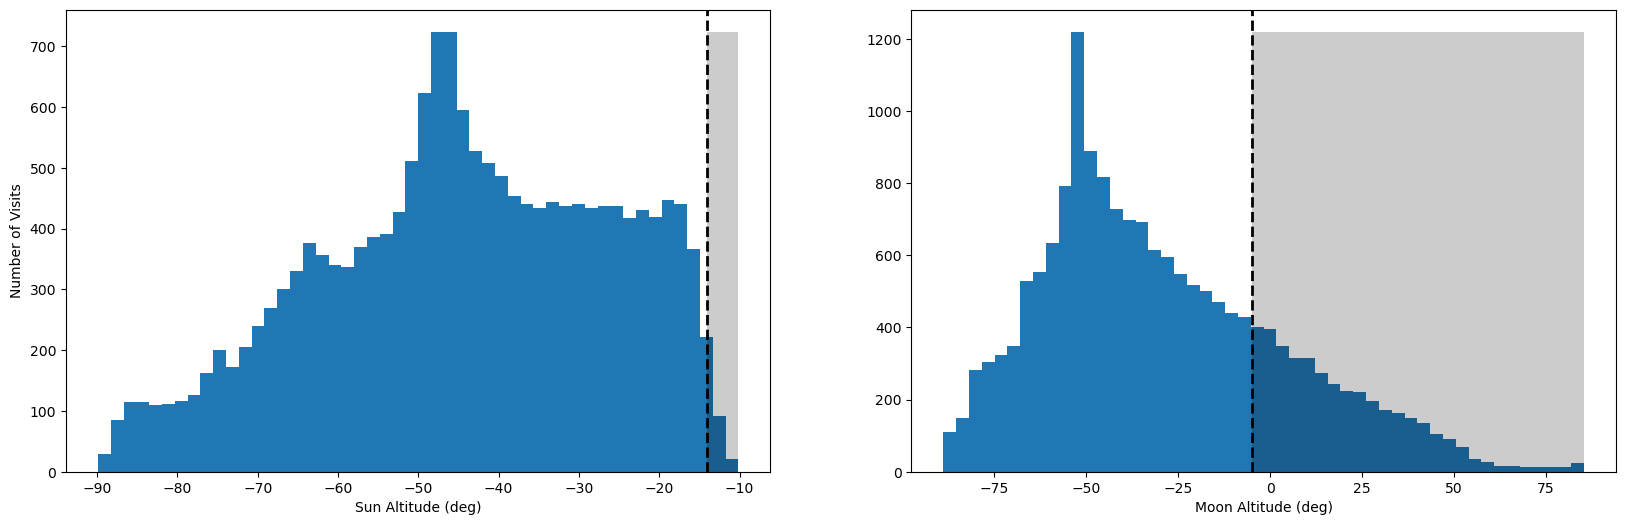

In [6]:
# Plot sun/moon restrictions
fig, axes = plt.subplots(1,2, figsize=(20,6))
num,edges,_ = axes[0].hist(sun_altaz.alt, bins=50)
axes[0].axvline(-14,ls='--',color='k',lw=2)
axes[0].fill_between([-14,edges.max()],0,num.max(),alpha=0.2,facecolor='k')
axes[0].set_xlabel('Sun Altitude (deg)')

num,edges,_ = axes[1].hist(moon_altaz.alt,bins=50)
axes[1].axvline(-5,ls='--',color='k',lw=2)
axes[1].fill_between([-5,edges.max()],0,num.max(),alpha=0.2,facecolor='k')
axes[1].set_xlabel('Moon Altitude (deg)')

axes[0].set_ylabel("Number of Visits")

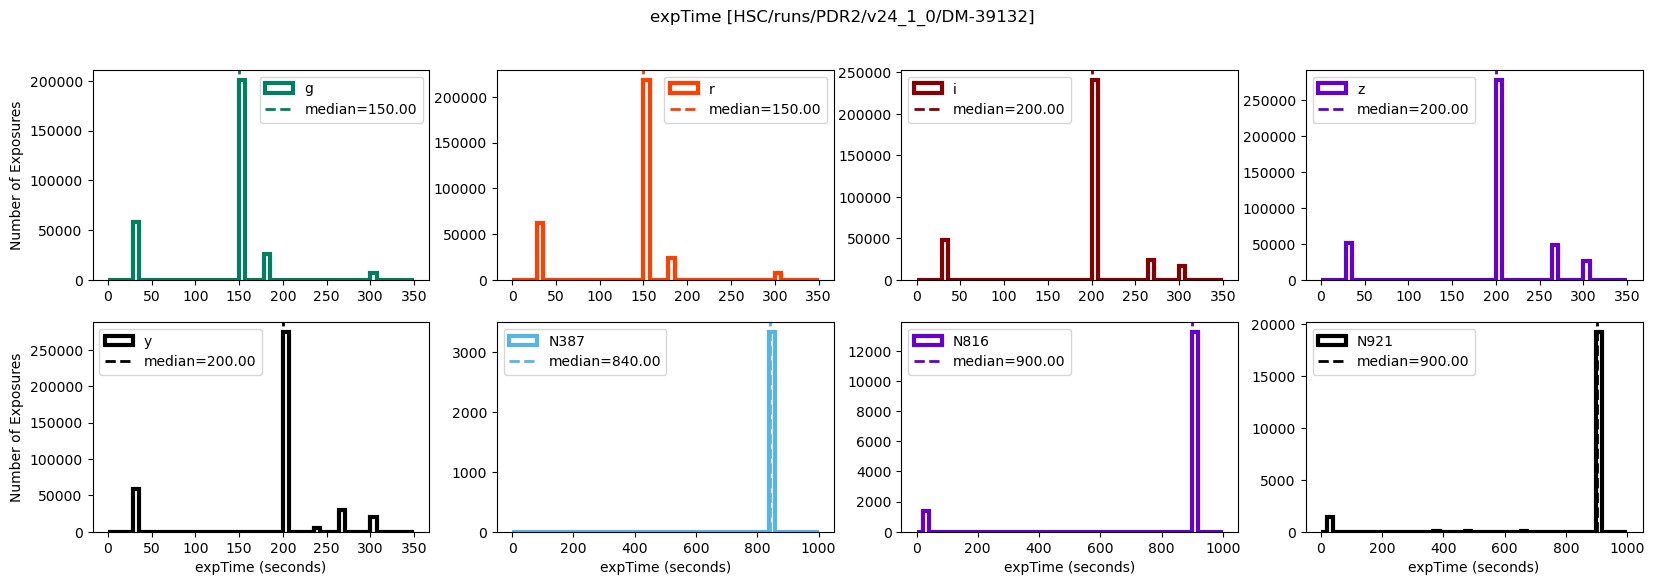

In [7]:
# Investigate the exposure time distribution.
# Probably want to exclude short exposures (standards?)
var = 'expTime'
label = f"{var} (seconds)"
data = {b: table[table['band']==b][var] for b in BANDS}
bins = {
    'g': np.linspace(0,350),
    'r': np.linspace(0,350),
    'i': np.linspace(0,350),
    'z': np.linspace(0,350),
    'y': np.linspace(0,350),
    'N387': np.linspace(0,1000),
    'N816': np.linspace(0,1000),
    'N921': np.linspace(0,1000),
}

_, (fig, axes) = plot_variable(var, data, bins, label)

In [8]:
# Apply some quality selections
# Our goal is to select exposures that are taken close to zenith under clear, dark-sky conditions.

sel  = tableVisit['zenithDistance'] < 30 # secz < 1.15
sel &= (tableVisit['expTime'] > 55)
sel &= (sun_altaz.alt.deg < -14)
sel &= (moon_altaz.alt.deg < -5)

sel = np.in1d(table['visitId'], tableVisit[sel]['visitId'])

# Subset of tables
tab = table[sel]
tabVisit = select_unique_visits(tab)
assert (np.unique(tabVisit['visitId']) ==  np.unique(tab['visitId'])).all()

print("All visits:")
print(tableVisit.groupby('band')['visitId'].count())

print("Selected visits:")
print(tabVisit.groupby('band')['visitId'].count())

# If we want to save the data...
if False:
    outfile='pdr2_ccdVisitTable_subset.csv.gz'
    print(f"Writing {outfile}...")
    tab.to_csv(outfile, compression='gzip')

All visits:
band
N387      41
N816     143
N921     204
g       2838
i       3202
r       3042
y       3786
z       3927
Name: visitId, dtype: int64
Selected visits:
band
N387      20
N816      39
N921      56
g        813
i       1073
r        981
y        899
z       1178
Name: visitId, dtype: int64


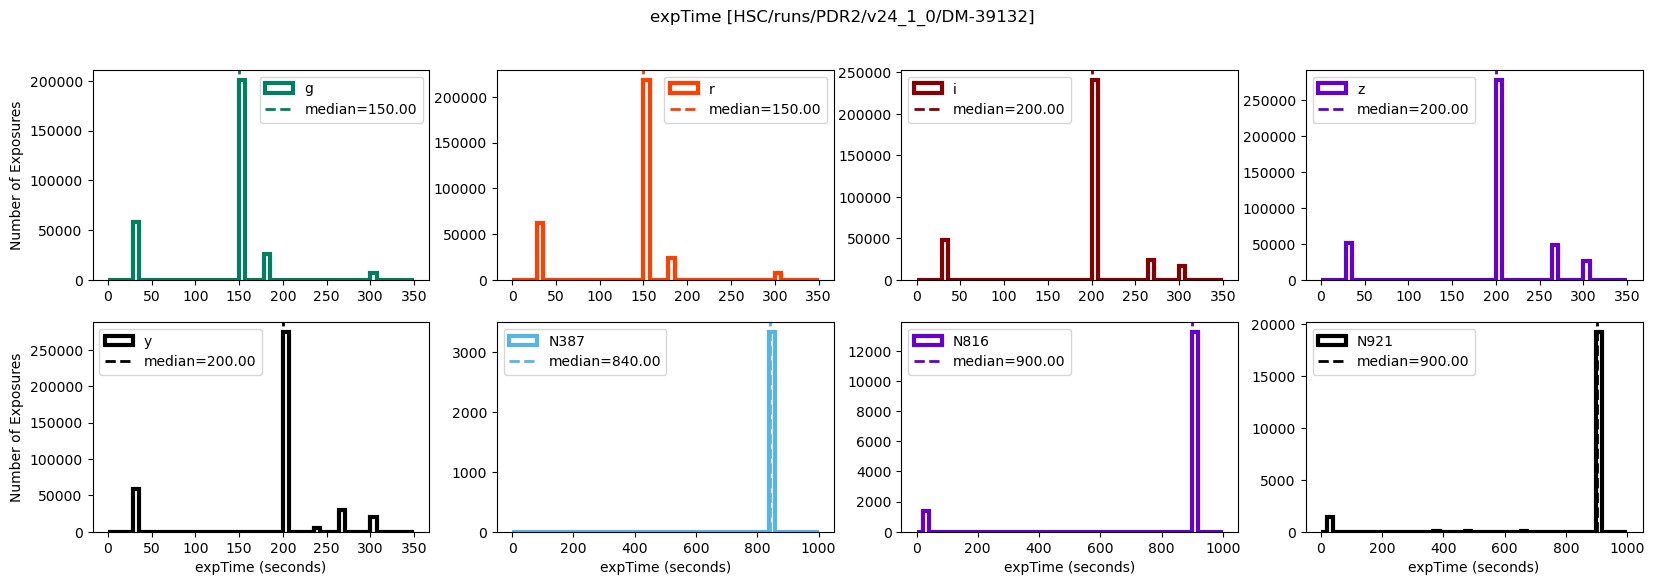

In [9]:
var = 'expTime'
label = f"{var} (seconds)"
data = {b: table[table['band']==b][var] for b in BANDS}
bins = {
    'g': np.linspace(0,350),
    'r': np.linspace(0,350),
    'i': np.linspace(0,350),
    'z': np.linspace(0,350),
    'y': np.linspace(0,350),
    'N387': np.linspace(0,1000),
    'N816': np.linspace(0,1000),
    'N921': np.linspace(0,1000),
}

_, (fig, axes) = plot_variable(var, data, bins, label)

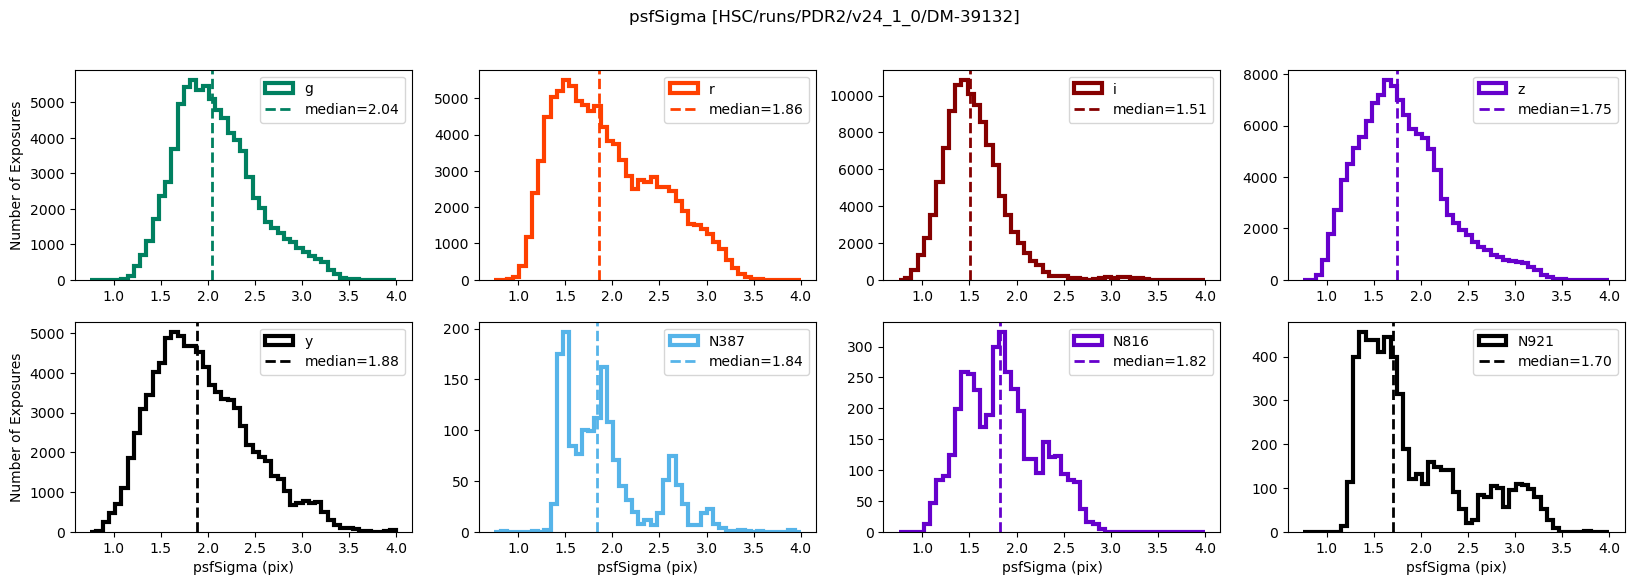

In [10]:
var = 'psfSigma'
label = f"{var} (pix)"
data = {b: tab[tab['band']==b][var] for b in BANDS}
bins = {b: np.linspace(0.75,4.0) for b in BANDS}

fiducial_psf, (fig, axes) = plot_variable(var, data, bins, label)

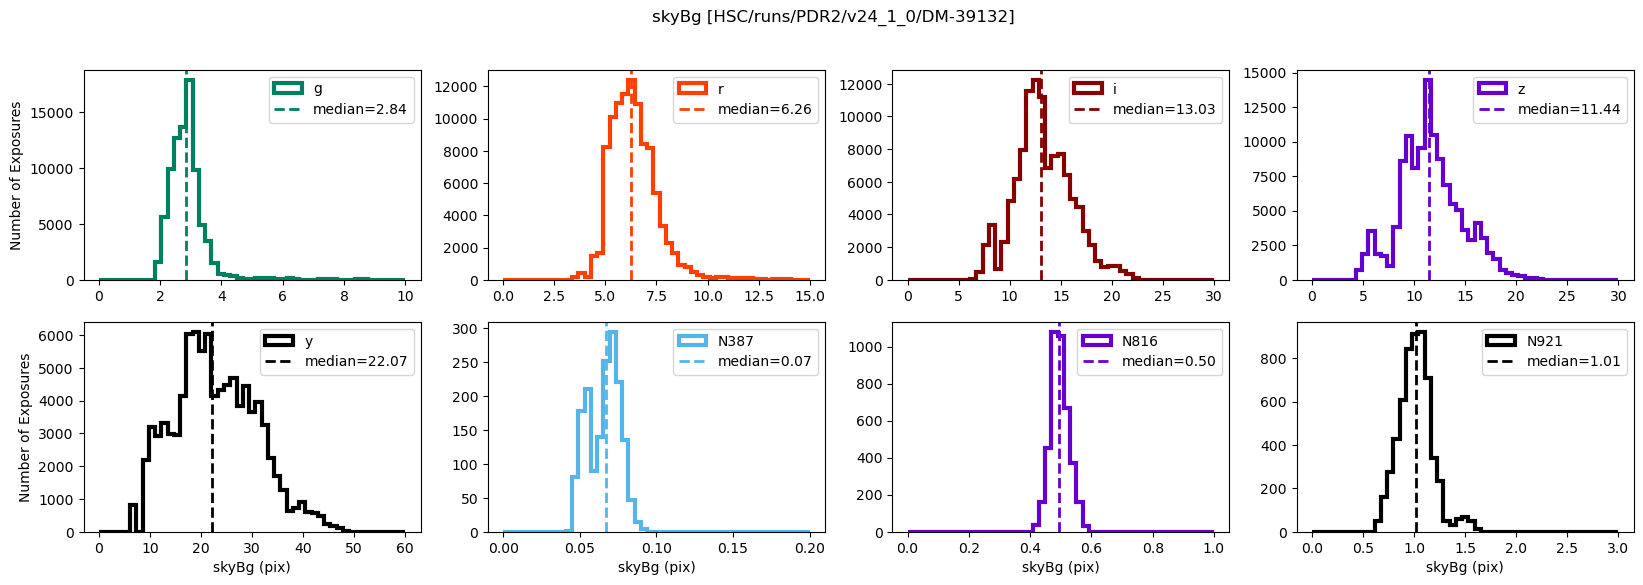

In [11]:
var = 'skyBg'
label = f"{var} (pix)"
data = {b: tab[tab['band']==b][var]/tab[tab['band']==b]['expTime'] for b in BANDS}
bins = {
    'g': np.linspace(0,10),
    'r': np.linspace(0,15),
    'i': np.linspace(0,30),
    'z': np.linspace(0,30),
    'y': np.linspace(0,60),
    'N387': np.linspace(0,0.2),
    'N816': np.linspace(0,1),
    'N921': np.linspace(0,3),
}

fiducial_sky, (fig, axes) = plot_variable(var, data, bins, label)

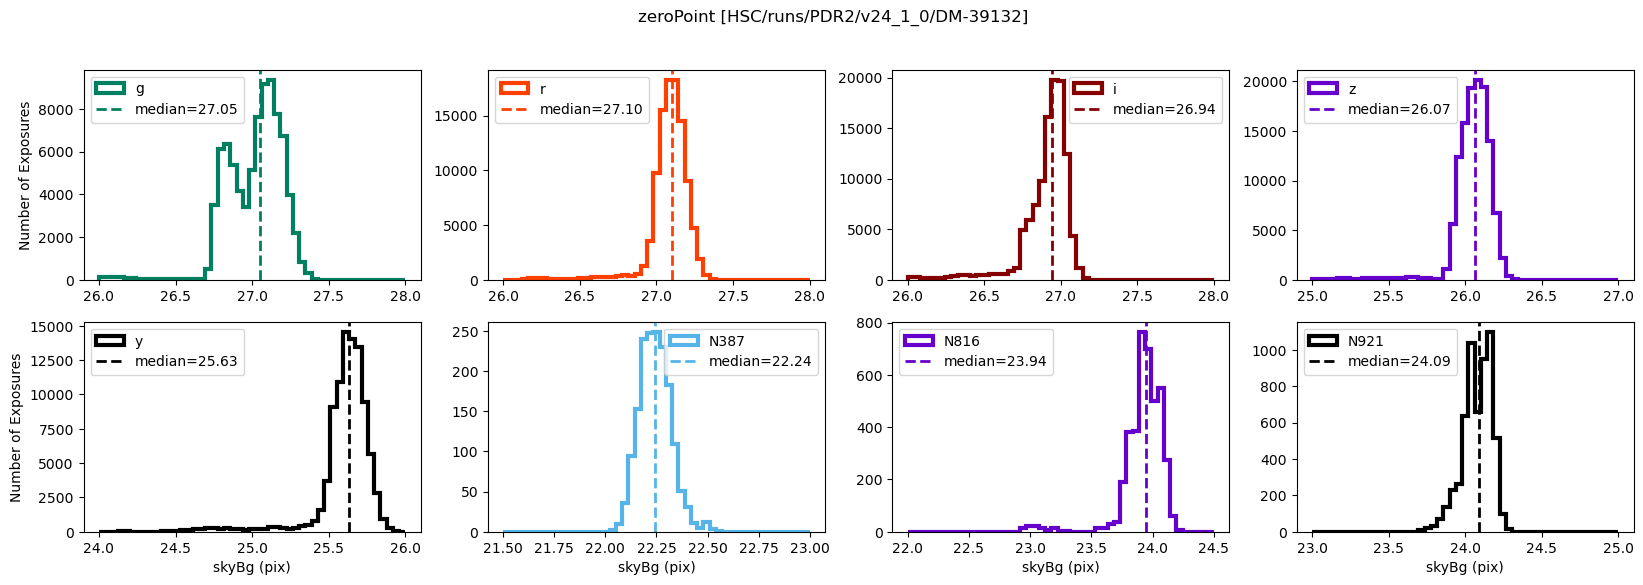

In [12]:
var = 'zeroPoint'
xlabel = f"{var}"
data = {b: tab[tab['band']==b][var]- 2.5*np.log10(tab[tab['band']==b]['expTime']) for b in BANDS}
bins = {
    'g': np.linspace(26,28),
    'r': np.linspace(26,28),
    'i': np.linspace(26,28),
    'z': np.linspace(25,27),
    'y': np.linspace(24,26),
    'N387': np.linspace(21.5,23),
    'N816': np.linspace(22,24.5),
    'N921': np.linspace(23,25),
}

fiducial_zeropoint, (fig, axes) = plot_variable(var, data, bins, label)

The resulting fiducial values get placed in the [computeVisitSummaryStats.py](https://github.com/lsst/obs_subaru/blob/tickets/DM-42080/config/computeExposureSummaryStats.py) configuration file in `obs_subaru/config`. An example of the formatting can be found below:

```python

config.fiducialPsfSigma = {
    'u': 2.0,
    'g': 2.04,
    'r': 1.86,
    'i': 1.51,
    'z': 1.75,
    'y': 1.88,
    'N387': 1.84,
    'N816': 1.82,
    'N921': 1.70,
}
config.fiducialSkyBackground = {
    'u': 1.0,
    'g': 2.84,
    'r': 6.26,
    'i': 13.03,
    'z': 11.44,
    'y': 22.07,
    'N387': 0.07,
    'N816': 0.50,
    'N921': 1.01,
}
config.fiducialZeroPoint = {
    'u': 26.0,
    'g': 27.05,
    'r': 27.10,
    'i': 26.94,
    'z': 26.07,
    'y': 25.63,
    'N387': 22.24,
    'N816': 23.94,
    'N921': 24.09,
}
```